In [1]:
import os
import random
import sys
import cv2
import imageio.v2 as imageio
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adadelta, Adam
from keras_preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tqdm import tqdm
from keras.initializers import GlorotNormal
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from pathlib import Path

2023-04-15 22:36:52.039331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Set a random seed for reproducibility
random.seed(42)

# Set the path to the InterdisciplinaryDataAnalysisClass_FinalDataSet folder on your local machine
data_folder_path = '/Users/jay/InterdisciplinaryDataAnalysisClass_FinalDataSet'

# Construct the file path for the metadata file
data_folder = Path(data_folder_path)
metadata_file_path = data_folder / 'sampleMetadata_concatenated.txt'

# Read the metadata file as a pandas DataFrame and define folder_names for image folders
metaData = pd.read_csv(metadata_file_path, sep='\t', dtype={'Timestamp': str})
folder_names = ['Local', 'Overview', 'Window', 'Pixel']

# Create a dictionary to store image arrays for 'Local', 'Overview', and 'Window' folders
image_arrays = {folder_name.lower() + '_images': [] for folder_name in ['Local', 'Overview', 'Window']}

# Initialize a StandardScaler object for normalizing the images before training
scaler = StandardScaler()

In [9]:
# Randomly select a specified number of samples from the metadata
num_samples = 48000
indices = random.sample(range(metaData.shape[0]), num_samples)

# Create a new DataFrame with only the selected entries
metaData_sample = metaData.iloc[indices].reset_index(drop=True)

# Add new columns to store the extracted RGB values
metaData_sample['R'] = 0
metaData_sample['G'] = 0
metaData_sample['B'] = 0

# Loop through the selected indices and process the images
for i in tqdm(indices):
    # Loop through the folder names (Local, Overview, Window, Pixel)
    for folder_name in folder_names:
        # Construct the image file path using the data folder path, folder name, sample number, and timestamp
        img_path = f'{data_folder_path}/{folder_name}/{folder_name.lower()}.{metaData["Sample Number"][i]}.{metaData["Timestamp"][i]}.png'
        
        # Check if the image file exists
        if os.path.exists(img_path):
            # Read the image using OpenCV and convert from BGR to RGB color space
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize the image for 'Overview' and 'Montage' folders
            if folder_name in ['Overview', 'Montage']:
                img = cv2.resize(img, (100, 100))

            # For 'Pixel' folder, extract RGB values and store them in the metadata dataframe
            if folder_name == 'Pixel':
                center_rgb = img[0, 0] / 255
                metaData_sample.loc[metaData_sample['Sample Number'] == metaData["Sample Number"][i], ['R', 'G', 'B']] = center_rgb
            else:
                # Reshape the image into a 2D array for scaling
                img_2d = img.reshape(-1, img.shape[-1])
                
                # Scale the image using StandardScaler
                img_scaled = scaler.fit_transform(img_2d)
                
                # Reshape the scaled image back to its original shape
                img = img_scaled.reshape(img.shape)
                
                # Append the processed image to the corresponding image_arrays entry
                image_arrays[folder_name.lower() + '_images'].append(img)


100%|████████████████████████████████████| 48000/48000 [05:35<00:00, 143.13it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of local images: 48000
Number of overview images: 48000
Number of window images: 48000
Local image shape: (7, 7, 3)


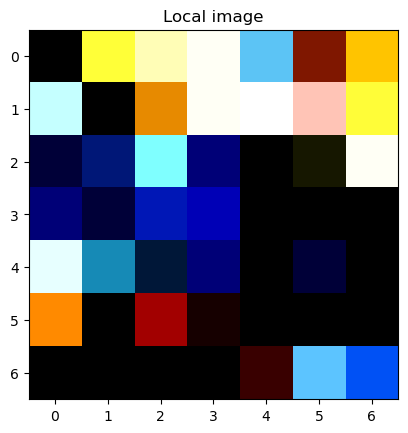

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Overview image shape: (100, 100, 3)


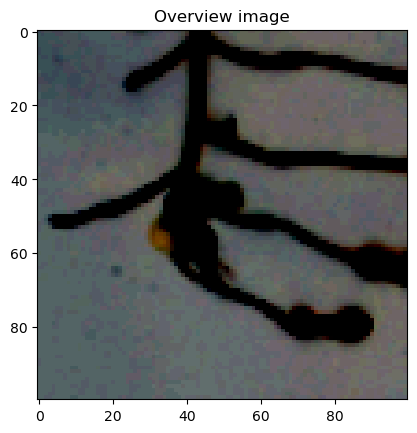

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Window image shape: (31, 31, 3)


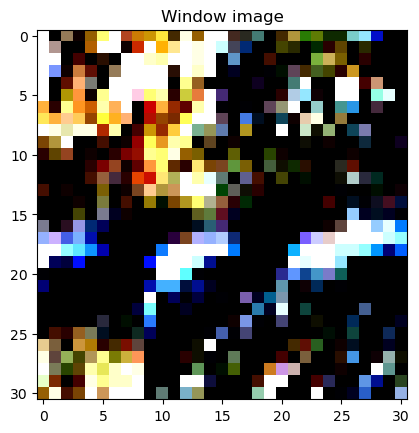

In [10]:
# Check the number of images loaded in each folder
folder_names = ['Local', 'Overview', 'Window']
for folder_name in folder_names:
    print(f"Number of {folder_name.lower()} images: {len(image_arrays[folder_name.lower() + '_images'])}")

# Display a random image from each folder
for folder_name in folder_names:
    random_index = np.random.randint(len(image_arrays[folder_name.lower() + '_images']))
    img = image_arrays[folder_name.lower() + '_images'][random_index]
    print(f"{folder_name} image shape: {img.shape}")
    plt.imshow(img)
    plt.title(f"{folder_name} image")
    plt.show()


In [11]:
# Categorical columns of the data frame, ordered by the number of occurences of each class
categorical_columns = ['HerbariumSheet', 'Plant', 'Inflorescence', 'External', 'Text', 'FlowerFruit', 
                       'Vegetative', 'Typed', 'Leaf', 'Border', 'DataLabel', 'BorderDifferentComponents', 
                       'ColorBarRuler', 'DeterminationSlip', 'Stem', 'Lamina', 'Background', 'Barcode', 
                       'ColorBoxMatrix', 'InstitutionalInsigniaIcon', 'Handwritten', 'Envelope', 
                       'AccessionInformation', 'BarsDemarcationLines', 'Damage', 'TapeString', 'Glue', 
                       'Petiole', 'Tendril', 'BorderSameComponents', 'HerbariumSheetMargin', 'Other']

# Specify the number of classes that you want the model to consider and extract them to a list
num_classes = 16 
top_classes = categorical_columns[:num_classes]

# Extract the numerical data from the specified columns in the metaData_sample DataFrame
mlp_input = metaData_sample[['X Scaled', 'Y Scaled', 'Attribute Number', 'R', 'G', 'B']].values

# Convert the list of 'local_images' to a NumPy array
local_images = np.array(image_arrays['local_images'])

# Convert the list of 'overview_images' to a NumPy array
overview_images = np.array(image_arrays['overview_images'])

# Convert the list of 'window_images' to a NumPy array
window_images = np.array(image_arrays['window_images'])

In [12]:
# Extract the target values (y) from the metaData_sample DataFrame
y = metaData_sample[top_classes].values

# Set the split ratio for training and validation sets
split_ratio = 0.8

# Split the data into training and validation sets using the train_test_split function
(
    local_train, local_val, 
    overview_train, overview_val, 
    window_train, window_val, 
    mlp_train, mlp_val, 
    y_train, y_val
) = train_test_split(
    local_images, overview_images, window_images, mlp_input, y,
    train_size=split_ratio, random_state=42
)


In [13]:
# Define the window branch of the CNN
def create_window_branch(input_shape):
    input_layer = Input(shape=input_shape, name="window_input")
    x = Conv2D(32, kernel_size=(3, 3), kernel_initializer=GlorotNormal(), activation='relu', name="window_conv1")(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(4, 4), name="window_maxpool1")(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(3, 3), kernel_initializer=GlorotNormal(), activation='relu', name="window_conv2")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(4, 4), name="window_maxpool2")(x)
    x = Dropout(0.25)(x)
    x = Flatten(name="window_flatten")(x)
    return input_layer, x

# Define the overview branch of the CNN
def create_overview_branch(input_shape):
    input_layer = Input(shape=input_shape, name="overview_input")
    x = Conv2D(32, kernel_size=(3, 3), kernel_initializer=GlorotNormal(), activation='relu', name="overview_conv1")(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name="overview_maxpool1")(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=(2, 2), kernel_initializer=GlorotNormal(), activation='relu', name="overview_conv2")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name="overview_maxpool2")(x)
    x = Dropout(0.25)(x)
    x = Flatten(name="overview_flatten")(x)
    return input_layer, x

# Define the local branch of the CNN
def create_local_branch(input_shape):
    input_layer = Input(shape=input_shape, name="local_input")
    x = Conv2D(16, kernel_size=(3, 3), kernel_initializer=GlorotNormal(), activation = 'relu', name = "local_conv1")(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), name="local_maxpool1")(x)
    x = Dropout(0.25)(x)
    x = Flatten(name="local_flatten")(x)
    return input_layer, x

# Define the MLP for categorical data
def create_mlp_branch(input_shape, name):
    input_layer = Input(shape=input_shape, name=f"{name}_input")
    x = Dense(128, activation='relu', name=f"{name}_dense1")(input_layer)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu', name=f"{name}_dense2")(x)
    return input_layer, x


In [19]:
# Create CNN branches for each image type
local_input, local_branch = create_local_branch(input_shape=(7, 7, 3))
overview_input, overview_branch = create_overview_branch(input_shape=(100, 100, 3))
window_input, window_branch = create_window_branch(input_shape=(31, 31, 3))

# Create MLP branch 
categorical_input, categorical_branch = create_mlp_branch(input_shape=(6,), name='MLP')

# Concatenate the outputs of each branch
concatenated = Concatenate()([local_branch, overview_branch, window_branch, categorical_branch])

# Add a fully connected layer
fc = Dense(128, activation='relu')(concatenated)
fc = Dropout(0.25)(fc) 
fc = Dense(64, activation='relu')(fc)
fc = Dropout(0.25)(fc) 
fc = Dense(32, activation='relu')(fc)
fc = Dropout(0.25)(fc) 
fc = Dense(32, activation='relu')(fc)
categorical_output = Dense(num_classes, activation='sigmoid', name='categorical_output')(fc)

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)

# Create and compile the model
model = Model(inputs=[local_input, overview_input, window_input, categorical_input], outputs=[categorical_output])
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['categorical_accuracy'])

# Display the model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 overview_input (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 window_input (InputLayer)      [(None, 31, 31, 3)]  0           []                               
                                                                                                  
 overview_conv1 (Conv2D)        (None, 98, 98, 32)   896         ['overview_input[0][0]']         
                                                                                                  
 window_conv1 (Conv2D)          (None, 29, 29, 32)   896         ['window_input[0][0]']     

                                                                                                  
 dense_9 (Dense)                (None, 32)           2080        ['dropout_29[0][0]']             
                                                                                                  
 dropout_30 (Dropout)           (None, 32)           0           ['dense_9[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 32)           1056        ['dropout_30[0][0]']             
                                                                                                  
 categorical_output (Dense)     (None, 16)           528         ['dense_10[0][0]']               
                                                                                                  
Total params: 4,794,192
Trainable params: 4,793,776
Non-trainable params: 416
_______________________________

In [20]:
# Converges in ~3 epochs

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_modelmini.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, min_lr=1e-10, verbose=1)

# Train the model
batch_size = 128
epochs = 10
history = model.fit(
    [local_train, overview_train, window_train, mlp_train],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([local_val, overview_val, window_val, mlp_val], y_val),
    callbacks=[lr_scheduler, checkpoint]
)

# Save the model
model.save('/Users/Jay/InterdisciplinaryDataAnalysisClass_FinalDataSet/')

Epoch 1/40
300/300 [==============================] - 206s 679ms/step - loss: 0.3496 - categorical_accuracy: 0.8052 - val_loss: 0.8239 - val_categorical_accuracy: 0.8794 - lr: 0.0010
Epoch 2/40
300/300 [==============================] - 202s 672ms/step - loss: 0.2223 - categorical_accuracy: 0.9539 - val_loss: 0.2452 - val_categorical_accuracy: 0.9392 - lr: 0.0010
Epoch 3/40
300/300 [==============================] - 190s 634ms/step - loss: 0.1875 - categorical_accuracy: 0.9642 - val_loss: 0.1662 - val_categorical_accuracy: 0.9727 - lr: 0.0010
Epoch 4/40
300/300 [==============================] - 187s 624ms/step - loss: 0.1636 - categorical_accuracy: 0.9656 - val_loss: 0.1448 - val_categorical_accuracy: 0.9733 - lr: 0.0010
Epoch 5/40
300/300 [==============================] - 186s 621ms/step - loss: 0.1431 - categorical_accuracy: 0.9667 - val_loss: 0.1271 - val_categorical_accuracy: 0.9661 - lr: 0.0010
Epoch 6/40
300/300 [==============================] - 187s 622ms/step - loss: 0.1306 

Epoch 36/40
300/300 [==============================] - 185s 617ms/step - loss: 0.0650 - categorical_accuracy: 0.9533 - val_loss: 0.0885 - val_categorical_accuracy: 0.9673 - lr: 9.7656e-07
Epoch 37/40
300/300 [==============================] - 187s 623ms/step - loss: 0.0657 - categorical_accuracy: 0.9527 - val_loss: 0.0885 - val_categorical_accuracy: 0.9676 - lr: 9.7656e-07
Epoch 38/40
300/300 [==============================] - ETA: 0s - loss: 0.0654 - categorical_accuracy: 0.9535
Epoch 38: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
300/300 [==============================] - 185s 617ms/step - loss: 0.0654 - categorical_accuracy: 0.9535 - val_loss: 0.0882 - val_categorical_accuracy: 0.9675 - lr: 9.7656e-07
Epoch 39/40
300/300 [==============================] - 186s 620ms/step - loss: 0.0650 - categorical_accuracy: 0.9533 - val_loss: 0.0884 - val_categorical_accuracy: 0.9673 - lr: 4.8828e-07
Epoch 40/40
300/300 [==============================] - 186s 620ms/step - l

INFO:tensorflow:Assets written to: /Users/Jay/InterdisciplinaryDataAnalysisClass_FinalDataSet/assets


INFO:tensorflow:Assets written to: /Users/Jay/InterdisciplinaryDataAnalysisClass_FinalDataSet/assets


In [29]:
# Read in the model
#model = keras.models.load_model('/Users/Jay/InterdisciplinaryDataAnalysisClass_FinalDataSet/saved_model.pb')
#model = tf.keras.models.load_model('/Users/Jay/InterdisciplinaryDataAnalysisClass_FinalDataSet/saved_model.pb')
# Load the new image
img = cv2.imread('/Users/Jay/InterdisciplinaryDataAnalysisClass_FinalDataSet/PreSeg Images/Passiflora_amalocarpa_1d81d781-b882-4754-a8f4-502983c5b290.jpg')

# Reshape the image into a 2D array for scaling
img_2d = img.reshape(-1, img.shape[-1])

# Scale the image using StandardScaler
img_scaled = scaler.fit_transform(img_2d)
img = cv2.resize(img, (700, 700))
# Reshape the scaled image back to its original shape
#img = img_scaled.reshape(img.shape)
# Define the border size
border_size = 50

# Add padding to the image
img = cv2.copyMakeBorder(img, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=0)

# Get the dimensions of the image
h, w, _ = img.shape

# Create a blank numpy array to hold the output segmented image
output = np.zeros((h, w, num_classes), dtype=np.uint8)

# Loop through each pixel in the image
for i in range(h):
    for j in range(w):
        
        # Extract the local, overview, window, and categorical data for the pixel
        local_data = img[max(0, i-3):min(i+4, h), max(0, j-3):min(j+4, w)]
        overview_data = img[max(0, i-50):min(i+51, h), max(0, j-50):min(j+51, w)]
        window_data = img[max(0, i-15):min(i+16, h), max(0, j-15):min(j+16, w)]


        # Reshape the data for the model
        local_data = np.reshape(local_data, (1, 7, 7, 3))
        overview_data = np.reshape(overview_data, (1, 100, 100, 3))
        window_data = np.reshape(window_data, (1, 31, 31, 3))
        categorical_data = np.reshape(categorical_data, (1, 6))

        # Predict the class probabilities for the pixel
        probabilities = model.predict([local_data, overview_data, window_data, categorical_data])[0]

        # Loop through each class and generate a color-coded image
        for k in range(16):
            # Set the alpha value of the pixel based on the probability of the pixel belonging to this class
            alpha = int(probabilities[k]*255)
            # Create a solid color image for this class
            color_img = np.zeros((h, w, 3), dtype=np.uint8)
            color_img[:] = (0, 0, 255) # Replace with your desired color for this class
            # Set the alpha value for each pixel in the color image
            color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2BGRA)
            color_img[:, :, 3] = alpha
            # Add the color image to the output image
            output += color_img

# Superimpose the output image on top of the original image
output = cv2.addWeighted(img, 0.7, output, 0.3, 0)

# Save the segmented image
cv2.imwrite('segmented_image.jpg', output)


ValueError: cannot reshape array of size 48 into shape (1,7,7,3)

In [28]:
print(local_data.shape)
print(local_data.size)


(4, 4, 3)
48
